# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from pandas.core.arrays.numeric import T
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
np.random.seed(1)

# Pre-Preprocessing

In [4]:
# Preprocessing
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define vectorizers
cv1 = CountVectorizer(min_df=100)
cv2 = CountVectorizer(min_df=100)
# Define Vectorizer
cv3 = CountVectorizer(min_df=500)
cv4 = CountVectorizer(min_df=500)

In [5]:
# Function which lowercases and tokenizes a review
def tokenizeReview(review, tokenizer):
    lowercase_review = review.lower()
    tokenized_review = tokenizer.tokenize(lowercase_review)
    return tokenized_review

# Function which removes stopwords from a tokenized review
def removeStopwordsReview(review):
    stopwordsSet = set(stopwords.words('english'))
    negations = set(['not', 'no', 'nor'])
    stopwords_removed_review = [word for word in review if word not in (stopwordsSet-negations) and len(word) > 1]
    return stopwords_removed_review

# Function which lemmatizes words of a review
def lemmatizeReview(review, lemmatizer):
    lemmatized_review = [lemmatizer.lemmatize(word) for word in review]
    return lemmatized_review

# Function which stems words of a review
def stemReview(review, stemmer):
    stemmed_review = [stemmer.stem(word) for word in review]
    return stemmed_review

# Function which tokenizes, lemmatizes and stems a review
def cleanReview(review, tokenizer, lemmatizer, stemmer):
    return stemReview(lemmatizeReview(removeStopwordsReview(tokenizeReview(review, tokenizer)), lemmatizer), stemmer)

# Preprocessing

## News Data

In [6]:
## Run this for getting the 20newsgroups data

# Raw Data Only Tokenizer Train
twenty_train = fetch_20newsgroups(subset='train',  remove=(['headers', 'footers', 'quotes']))
twenty_train_x = pd.DataFrame(data=twenty_train.data, columns=['data'])
twenty_train_x['data'] = twenty_train_x['data'].apply(lambda x: " ".join(tokenizeReview(x, tokenizer)))

# Raw Data Tokenizer + Stopwords + Lemma + Stem
twenty_train_tsls = fetch_20newsgroups(subset='train',  remove=(['headers', 'footers', 'quotes']))
twenty_train_tsls_x = pd.DataFrame(data=twenty_train_tsls.data, columns=['data'])
twenty_train_tsls_x['data'] = twenty_train_tsls_x['data'].apply(lambda x: " ".join(cleanReview(x, tokenizer, lemmatizer, stemmer)))

# Raw Data Only Tokenizer Test
twenty_test = fetch_20newsgroups(subset='test',  remove=(['headers', 'footers', 'quotes']))
twenty_test_x = pd.DataFrame(data=twenty_test.data, columns=['data'])
twenty_test_x['data'] = twenty_test_x['data'].apply(lambda x: " ".join(tokenizeReview(x, tokenizer)))

# Raw Data Only Tokenizer Test
twenty_test_tsls = fetch_20newsgroups(subset='test',  remove=(['headers', 'footers', 'quotes']))
twenty_test_tsls_x = pd.DataFrame(data=twenty_test_tsls.data, columns=['data'])
twenty_test_tsls_x['data'] = twenty_test_tsls_x['data'].apply(lambda x: " ".join(cleanReview(x, tokenizer, lemmatizer, stemmer)))



In [7]:
# Train Vectors
twenty_train_x_vec = cv1.fit_transform(twenty_train_x['data']).toarray()
twenty_train_tsls_x_vec = cv2.fit_transform(twenty_train_tsls_x['data']).toarray()
twenty_train_y_vec = twenty_train.target#.reshape(11314,1)

# Test Set
twenty_test_x_vec = cv1.transform(twenty_test_x['data']).toarray()
twenty_test_tsls_x_vec = cv2.transform(twenty_test_tsls_x['data']).toarray()
twenty_test_y_vec = twenty_test.target#.reshape(7532,1)

In [8]:
print(twenty_train_x_vec.shape)
print(twenty_train_tsls_x_vec.shape)
print(twenty_train_y_vec.shape)
print(twenty_test_x_vec.shape)
print(twenty_test_tsls_x_vec.shape)
print(twenty_test_y_vec.shape)
print(type(twenty_train_x_vec))
print(type(twenty_train_tsls_x_vec))
print(type(twenty_train_y_vec))
print(type(twenty_test_x_vec))
print(type(twenty_test_tsls_x_vec))
print(type(twenty_test_y_vec))

(11314, 1578)
(11314, 1451)
(11314,)
(7532, 1578)
(7532, 1451)
(7532,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


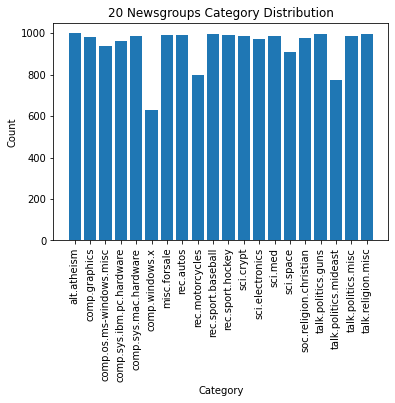

In [9]:
newsgroups_y = fetch_20newsgroups(subset='train').target_names
newsgroups_count = list(Counter(fetch_20newsgroups(subset='all').target).values())
newsgroups_count

plt.bar( newsgroups_y,newsgroups_count)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('20 Newsgroups Category Distribution')
plt.show()

## Sentiment140 Data

Move the training.1600000.processed.noemoticon.csv file to MyDrive and mount your drive

In [10]:
## Run this for getting the tweet data

# Raw Data
s140_train = pd.read_csv('./drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding='latin-1', usecols=[0,5], names=['y','data'])
s140_train.loc[s140_train['y']==4, 'y'] = 1

N = len(s140_train)
inds = np.random.permutation(N)
train_size = int(0.05*N)

s140_train_x = s140_train['data'].copy()[inds[:train_size]].apply(lambda x: " ".join(tokenizeReview(x, tokenizer)))
s140_train_tsls_x = s140_train['data'].copy()[inds[:train_size]].apply(lambda x: " ".join(cleanReview(x, tokenizer, lemmatizer, stemmer)))

s140_test = pd.read_csv('./drive/MyDrive/new_testdata.manual.2009.06.14.csv', encoding='latin-1', usecols=[0,5], names=['y','data'])
s140_test.loc[s140_test['y']==4, 'y'] = 1
s140_test_x = s140_test[['data']].copy()
s140_test_x['data']=s140_test_x['data'].apply(lambda x: " ".join(tokenizeReview(x, tokenizer)))
s140_test_tsls_x = s140_test[['data']].copy()
s140_test_tsls_x['data']=s140_test_tsls_x['data'].apply(lambda x: " ".join(cleanReview(x, tokenizer, lemmatizer, stemmer)))

In [11]:
s140_train_x.to_csv('./drive/MyDrive/s140_train_x.csv')
s140_train_tsls_x.to_csv('./drive/MyDrive/s140_train_tsls_x.csv')


In [12]:
# Train Vectors
s140_train_x_vec = cv3.fit_transform(s140_train_x.values.astype(str)).toarray()
s140_train_tsls_x_vec = cv4.fit_transform(s140_train_tsls_x.values.astype(str)).toarray()
s140_train_y_vec = s140_train['y'][inds[:train_size]].values#.reshape(1600000,1)

# Test Set
s140_test_x_vec = cv3.transform(s140_test_x['data']).toarray()
s140_test_tsls_x_vec = cv4.transform(s140_test_tsls_x['data']).toarray()
s140_test_y_vec = s140_test['y'].values#.reshape(359,1)

In [13]:
print(s140_train_x_vec.shape)
print(s140_train_tsls_x_vec.shape)
print(s140_train_y_vec.shape)
print(s140_test_x_vec.shape)
print(s140_test_tsls_x_vec.shape)
print(s140_test_y_vec.shape)
print(type(s140_train_x_vec))
print(type(s140_train_tsls_x_vec))
print(type(s140_train_y_vec))
print(type(s140_test_x_vec))
print(type(s140_test_tsls_x_vec))
print(type(s140_test_y_vec))

(80000, 266)
(80000, 188)
(80000,)
(359, 266)
(359, 188)
(359,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


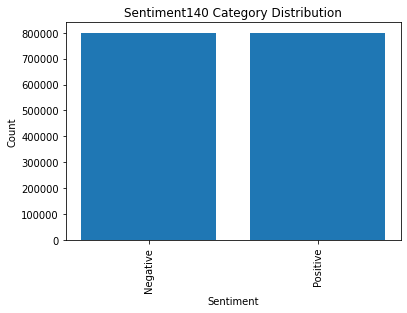

In [14]:

plt.bar(['Negative', 'Positive'] ,Counter(s140_train['y']).values())
plt.xticks(rotation=90)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment140 Category Distribution')
plt.show()

# Cross Validation

In [15]:
def evaluate_acc(y_predict, y_test):
  return np.sum(y_predict == y_test)/y_predict.shape[0]

class CrossValidation:
    def __init__(self):
        return

    def cross_validation_split(self, x, y, k):
        N = len(x)
        num_per_split = N // k
        output_x = []
        output_y = []
        inds = np.random.permutation(N)
        for i in range(k):
            if i==0:
                output_x.append(x[inds[:(i+1)*num_per_split]])
                output_y.append(y[inds[:(i+1)*num_per_split]])
            elif i==k-1:
                output_x.append(x[inds[(i)*num_per_split:]])
                output_y.append(y[inds[(i)*num_per_split:]])
            else:
                output_x.append(x[inds[(i)*num_per_split:(i+1)*num_per_split]])
                output_y.append(y[inds[(i)*num_per_split:(i+1)*num_per_split]])
        return output_x, output_y

    def kfoldCV(self, x, y, k, model):
        totalscore = 0
        for i in range(k):
            valid_x, valid_y = x[i], y[i]
            train_x, train_y = np.concatenate(tuple([a for index, a in enumerate(x) if i != index])), np.concatenate(tuple([a for index, a in enumerate(y) if i != index]))
            model.fit(train_x, train_y)
            y_pred = model.predict(valid_x)
            totalscore += evaluate_acc(y_pred, valid_y)
        return totalscore/k


        

# Naive Bayes

## Gaussian Naive Bayes

In [16]:
def logsumexp(Z):                               
    Zmax = np.max(Z,axis=0)[None,:]         
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

class GaussianNaiveBayes:
    
    def __init__(self, var_smoothing=0.005):
        self.var_smoothing = var_smoothing
        return

    def fit(self, x, y):
        N, D = x.shape
        labels = set(y)
        C = len(labels)
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C)
        for c in labels:
            x_c = x[y == c]
            Nc[c] = x_c.shape[0]
            mu[c,:] = np.mean(x_c,0)
            sigma[c,:] = np.std(x_c, 0)
            
        self.mu = mu
        self.sigma = sigma+self.var_smoothing
        self.pi = (Nc+1)/(N+C)
        return self

def predict(self, xt):
    Nt, D = xt.shape
    log_prior = np.log(self.pi)[:, None]
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
    log_likelihood = np.sum(log_likelihood, axis=2)
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return np.argmax(posterior.T,1) 

GaussianNaiveBayes.predict = predict



### Multinomial Naive Bayes

In [17]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha 

    def fit(self, x, y):
        N, D = x.shape
        self.C = np.unique(y)
        nC = len(self.C)
        self.prior = np.zeros(nC)
        self.likelihood = np.zeros((nC, D))

        for idx, c in enumerate(self.C):
            x_c = x[c == y]
            self.prior[idx] = x_c.shape[0] / N 
            self.likelihood[idx, :] = ((x_c.sum(axis=0)) + self.alpha) / (np.sum(x_c.sum(axis=0) + self.alpha))

    def predict_helper(self, x):
        posteriors = []
        for i, c in enumerate(self.C):
            posteriors.append(np.sum(np.log(self.likelihood[i,:]) * x) + np.log(self.prior[i]))

        return self.C[np.argmax(posteriors)]

    def predict(self, x):
        return np.array([self.predict_helper(row) for row in x])

# Testing

In [18]:
def percent_split(x,y,percent):
    N = len(x)
    inds = np.random.permutation(N)
    train_size = int(percent*N)
    return x[inds[:train_size]], y[inds[:train_size]]

In [19]:
cv = CrossValidation()
ttx, tty = cv.cross_validation_split(twenty_train_x_vec, twenty_train_y_vec, 5)
tttx, ttty = cv.cross_validation_split(twenty_train_tsls_x_vec, twenty_train_y_vec, 5)
stx, sty = cv.cross_validation_split(s140_train_x_vec, s140_train_y_vec, 5)
sttx, stty = cv.cross_validation_split(s140_train_tsls_x_vec, s140_train_y_vec, 5)

ttx_20, tty_20 = percent_split(twenty_train_x_vec, twenty_train_y_vec, 0.2)
ttx_40, tty_40 = percent_split(twenty_train_x_vec, twenty_train_y_vec, 0.4)
ttx_60, tty_60 = percent_split(twenty_train_x_vec, twenty_train_y_vec, 0.6)
ttx_80, tty_80 = percent_split(twenty_train_x_vec, twenty_train_y_vec, 0.8)
ttx_100, tty_100 = twenty_train_x_vec, twenty_train_y_vec

stx_20, sty_20 = percent_split(s140_train_x_vec, s140_train_y_vec, 0.2)
stx_40, sty_40 = percent_split(s140_train_x_vec, s140_train_y_vec, 0.4)
stx_60, sty_60 = percent_split(s140_train_x_vec, s140_train_y_vec, 0.6)
stx_80, sty_80 = percent_split(s140_train_x_vec, s140_train_y_vec, 0.8)
stx_100, sty_100 = s140_train_x_vec, s140_train_y_vec

ttxs = [ttx_20, ttx_40, ttx_60, ttx_80, ttx_100]
ttys = [tty_20, tty_40, tty_60, tty_80, tty_100]
stxs = [stx_20, stx_40, stx_60, stx_80, stx_100]
stys = [sty_20, sty_40, sty_60, sty_80, sty_100]

In [20]:
alpha = [1, 5, 10]
smoothing = [0.005, 0.05, 0.5]
max_iters = [50, 75, 100]
solvers = ['lbfgs']

In [21]:
GNB_tty_scores = []
MNB_tty_scores = []
LR_tty_scores = []
tty_test = []

for param in smoothing:
    print(param)
    GNB = GaussianNaiveBayes(param)
    GNB_tty_scores.append(cv.kfoldCV(ttx, tty, 5, GNB))
    tty_test.append(evaluate_acc(GNB.predict(twenty_test_x_vec), twenty_test_y_vec))

for param in alpha:
    print(param)
    MNB = MultinomialNaiveBayes(param)
    MNB_tty_scores.append(cv.kfoldCV(ttx, tty, 5, MNB))
    tty_test.append(evaluate_acc(MNB.predict(twenty_test_x_vec), twenty_test_y_vec))

for solver in solvers:
    for max_iter in max_iters:
        print(max_iter)
        LR = LogisticRegression(max_iter=max_iter, multi_class='multinomial', solver=solver)
        LR_tty_scores.append(cv.kfoldCV(ttx, tty, 5, LR))
        tty_test.append(evaluate_acc(LR.predict(twenty_test_x_vec), twenty_test_y_vec))

print(GNB_tty_scores)
print(MNB_tty_scores)
print(LR_tty_scores)
print(tty_test)

0.005
0.05
0.5
1
5
10
50


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


75


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.32852906495357115, 0.3190721565010149, 0.13001741033210737]
[0.5256299442104597, 0.5200594963567846, 0.4961982108952313]
[0.5266030030676834, 0.54764008449981, 0.5517908606291599]
[0.2858470525756771, 0.2858470525756771, 0.12161444503451939, 0.475570897503983, 0.4721189591078067, 0.45313329792883694, 0.46946362187997875, 0.4838024429102496, 0.4714551248008497]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [22]:
GNB_ttty_scores = []
MNB_ttty_scores = []
LR_ttty_scores = []
ttty_test = []

for param in smoothing:
    print(param)
    GNB = GaussianNaiveBayes(param)
    GNB_ttty_scores.append(cv.kfoldCV(tttx, ttty, 5, GNB))
    ttty_test.append(evaluate_acc(GNB.predict(twenty_test_tsls_x_vec), twenty_test_y_vec))

for param in alpha:
    print(param)
    MNB = MultinomialNaiveBayes(param)
    MNB_ttty_scores.append(cv.kfoldCV(tttx, ttty, 5, MNB))
    ttty_test.append(evaluate_acc(MNB.predict(twenty_test_tsls_x_vec), twenty_test_y_vec))

for solver in solvers:
    for max_iter in max_iters:
        print(max_iter)
        LR = LogisticRegression(max_iter=max_iter, multi_class='multinomial', solver=solver)
        LR_ttty_scores.append(cv.kfoldCV(tttx, ttty, 5, LR))
        ttty_test.append(evaluate_acc(LR.predict(twenty_test_tsls_x_vec), twenty_test_y_vec))

print(GNB_ttty_scores)
print(MNB_ttty_scores)
print(LR_ttty_scores)
print(ttty_test)

0.005
0.05
0.5
1
5
10
50


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


75


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


100


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.35425429385924867, 0.346921118163167, 0.12966280455399976]
[0.5784894605450347, 0.5719493875168464, 0.5664679812989154]
[0.5731011539515055, 0.5685937430497189, 0.5670892437547945]
[0.3104089219330855, 0.306558682952735, 0.1209506107275624, 0.5262878385554965, 0.5229686670207117, 0.521109930961232, 0.5116834838024429, 0.5088953797132236, 0.507036643653744]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [23]:
GNB_sty_scores = []
MNB_sty_scores = []
LR_sty_scores = []
sty_test = []

for param in smoothing:
    print(param)
    GNB = GaussianNaiveBayes(param)
    GNB_sty_scores.append(cv.kfoldCV(stx, sty, 5, GNB))
    sty_test.append(evaluate_acc(GNB.predict(s140_test_x_vec), s140_test_y_vec))
    
for param in alpha:
    print(param)
    MNB = MultinomialNaiveBayes(param)
    MNB_sty_scores.append(cv.kfoldCV(stx, sty, 5, MNB))
    sty_test.append(evaluate_acc(MNB.predict(s140_test_x_vec), s140_test_y_vec))

for solver in solvers:
    for max_iter in max_iters:
        print(max_iter)
        LR = LogisticRegression(max_iter=max_iter, multi_class='multinomial', solver=solver)
        LR_sty_scores.append(cv.kfoldCV(stx, sty, 5, LR))
        sty_test.append(evaluate_acc(LR.predict(s140_test_x_vec), s140_test_y_vec))

print(GNB_sty_scores)
print(MNB_sty_scores)
print(LR_sty_scores)
print(sty_test)

0.005
0.05
0.5
1
5
10
50


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


75
100
[0.6852375000000002, 0.6810375000000001, 0.50665]
[0.7102625, 0.710125, 0.7098749999999999]
[0.7182000000000001, 0.718225, 0.718225]
[0.6657381615598886, 0.6462395543175488, 0.5153203342618384, 0.6796657381615598, 0.6796657381615598, 0.6768802228412256, 0.6740947075208914, 0.6740947075208914, 0.6740947075208914]


In [24]:
GNB_stty_scores = []
MNB_stty_scores = []
LR_stty_scores = []
stty_test = []

for param in smoothing:
    print(param)
    GNB = GaussianNaiveBayes(param)
    GNB_stty_scores.append(cv.kfoldCV(sttx, stty, 5, GNB))
    stty_test.append(evaluate_acc(GNB.predict(s140_test_tsls_x_vec), s140_test_y_vec))

for param in alpha:
    print(param)
    MNB = MultinomialNaiveBayes(param)
    MNB_stty_scores.append(cv.kfoldCV(sttx, stty, 5, MNB))
    stty_test.append(evaluate_acc(MNB.predict(s140_test_tsls_x_vec), s140_test_y_vec))

for solver in solvers:
    for max_iter in max_iters:
        print(max_iter)
        LR = LogisticRegression(max_iter=max_iter, multi_class='multinomial', solver=solver)
        LR_stty_scores.append(cv.kfoldCV(sttx, stty, 5, LR))
        stty_test.append(evaluate_acc(LR.predict(s140_test_tsls_x_vec), s140_test_y_vec))

print(GNB_stty_scores)
print(MNB_stty_scores)
print(LR_stty_scores)
print(stty_test)

0.005
0.05
0.5
1
5
10
50
75
100
[0.6852500000000001, 0.686875, 0.5377875]
[0.6949875000000001, 0.6949750000000001, 0.6949]
[0.6994625, 0.6994625, 0.6994625]
[0.6880222841225627, 0.6657381615598886, 0.5181058495821727, 0.6796657381615598, 0.6796657381615598, 0.6824512534818942, 0.6991643454038997, 0.6991643454038997, 0.6991643454038997]


In [25]:
MNB_tty_size_scores = []
LR_tty_size_scores = []

MNB = MultinomialNaiveBayes(alpha=1)
LR = LogisticRegression(max_iter=100, multi_class='multinomial')

for i in range(len(ttxs)):
    MNB.fit(ttxs[i], ttys[i])
    MNB_tty_size_scores.append(evaluate_acc(MNB.predict(twenty_test_x_vec), twenty_test_y_vec))
    LR.fit(ttxs[i], ttys[i])
    LR_tty_size_scores.append(evaluate_acc(LR.predict(twenty_test_x_vec), twenty_test_y_vec))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
MNB_sty_size_scores = []
LR_sty_size_scores = []

MNB = MultinomialNaiveBayes(alpha=1)
LR = LogisticRegression(max_iter=100, multi_class='multinomial')

for i in range(len(stxs)):
    MNB.fit(stxs[i], stys[i])
    MNB_sty_size_scores.append(evaluate_acc(MNB.predict(s140_test_x_vec), s140_test_y_vec))
    LR.fit(stxs[i], stys[i])
    LR_sty_size_scores.append(evaluate_acc(LR.predict(s140_test_x_vec), s140_test_y_vec))

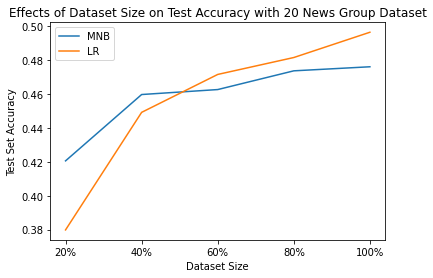

In [27]:
x = ['20%', '40%', '60%', '80%', '100%']

plt.plot(x, MNB_tty_size_scores, label='MNB')
plt.plot(x, LR_tty_size_scores, label='LR')
plt.xlabel("Dataset Size")
plt.ylabel("Test Set Accuracy")
plt.title("Effects of Dataset Size on Test Accuracy with 20 News Group Dataset")
plt.legend()
plt.show()

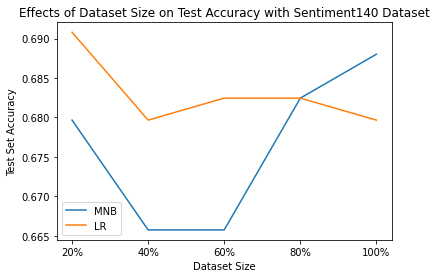

In [28]:
x = ['20%', '40%', '60%', '80%', '100%']

plt.plot(x, MNB_sty_size_scores, label='MNB')
plt.plot(x, LR_sty_size_scores, label='LR')
plt.xlabel("Dataset Size")
plt.ylabel("Test Set Accuracy")
plt.title("Effects of Dataset Size on Test Accuracy with Sentiment140 Dataset")
plt.legend()
plt.show()